In [1]:
import re, sys
import functools
import numpy as np
from graphviz import Digraph, Source
from pathlib import Path
from pynini import Weight

sys.path.append(str(Path.home() / 'Code/Python/wynini'))
from wynini import config as wconfig
from wynini import wfst
from wynini.wfst import *

/home/colin/Code/Python/wynini/wynini/wfst.py:1581: SyntaxWarning: invalid escape sequence '\o'
  """


In [2]:
help(wconfig)
wconfig.init({'sigma': ['a', 'b', 'c']})

Help on module wynini.config in wynini:

NAME
    wynini.config

FUNCTIONS
    init(config={})
        Set globals with dictionary or module

    make_symtable(sigma)

DATA
    bos = '⋊'
    eos = '⋉'
    epsilon = 'ϵ'
    sigma = ['a', 'b']
    special_syms = []
    syms = []
    symtable = None
    unk = '⊥'
    verbosity = 0
    λ = ''

FILE
    /home/colin/Code/Python/wynini/wynini/config.py




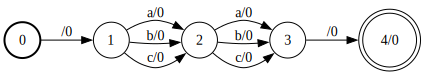

In [3]:
M = braid(2, arc_type='log')
one = Weight('log', 0.0)
M.assign_weights(lambda M, q, t: one)

#M = trellis(2)
#M = ngram(context='left', length=1)
M.draw('M.dot', show_weight_one=True)
M_viz = Source.from_file('M.dot')
M_viz

In [4]:
beta = shortestdistance(M, reverse=True)
beta = np.array([float(w) for w in beta])
print(np.exp(-beta))

[9.00000038 9.00000038 3.00000006 1.         1.        ]


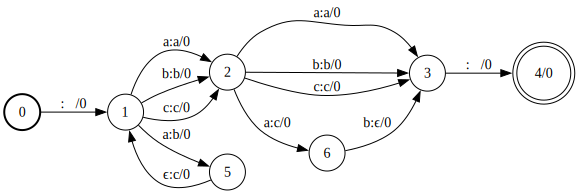

In [5]:
# Add paths.
M.add_path(src=1, ilabel='a', olabel='b c', weight=None, dest=1)
M.add_path(src=2, ilabel='a b', olabel='c', weight=None, dest=3)
M.draw('M.dot', show_weight_one=True)
M_viz = Source.from_file('M.dot')
M_viz

In [6]:
# Concatenation, union, optionality, star.
wfst1 = Wfst()
q0 = wfst1.add_state(initial=True)
q1 = wfst1.add_state(final=True)
wfst1.add_arc(q0, 'a', 'a', None, q1)
print(wfst1.print())

wfst2 = Wfst()
q0 = wfst2.add_state(initial=True)
q1 = wfst2.add_state(final=True)
wfst2.add_arc(q0, 'b', 'b', None, q1)
print(wfst2.print())

# Concatenation.
wfst12 = concat(wfst1, wfst2)
print(wfst12.print())

# Union.
wfst12 = union(wfst1, wfst2)
print(wfst12.print())

# Optionality.
wfst = ques(wfst1)
print(wfst.print())

# Star.
wfst = star(wfst1)
print(wfst.print())

0	1	a	a
1

0	1	b	b
1

(0, 1)	(1, 1)	a	a
(1, 1)	(0, 2)	ϵ	ϵ
(0, 2)	(1, 2)	b	b
(1, 2)

0	(0, 1)	ϵ	ϵ
0	(0, 2)	ϵ	ϵ
(0, 1)	(1, 1)	a	a
(1, 1)
(0, 2)	(1, 2)	b	b
(1, 2)

0	1	a	a
0	2	ϵ	ϵ
1
2

0	1	a	a
1	0	ϵ	ϵ
1



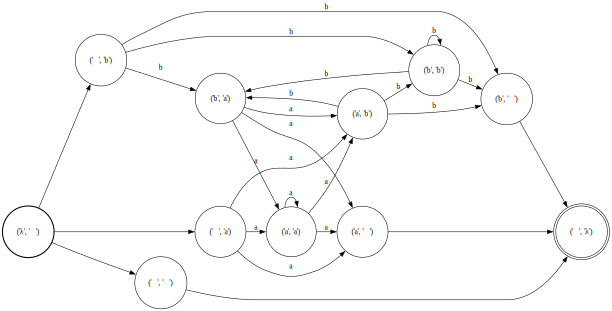

In [7]:
# N-gram machines.
config.init({'sigma': ['a', 'b']})
M = ngram(context='both', length=1)

# Flatten labels.
def relabel_func(wfst, q):
    label = wfst.state_label(q)
    label_ = tuple(' '.join(x) for x in label)
    return label_
M = M.relabel_states(relabel_func)

M.draw('M.dot', show_weight_one=False)
M_viz = Source.from_file('M.dot')
M_viz

In [10]:
# Matching functions in compose().
input_ = 'bab'
input_ = [f'{x}_{i}' for i, x in enumerate(input_)]
isymbols = set(input_)
input_ = accep(' '.join(input_), isymbols)
print(input_.print())

output_ = 'bab'
output_ = [x for x in output_]
osymbols = set(output_)
output_ = accep(' '.join(output_), osymbols)
print(output_.print())

M = compose(input_, output_, matchfunc1 = lambda x : re.sub('_[0-9]+$', '', x))
print(M.print())
# 

0	1	⋊	⋊
1	2	b_0	b_0
2	3	a_1	a_1
3	4	b_2	b_2
4	5	⋉	⋉
5

0	1	⋊	⋊
1	2	b	b
2	3	a	a
3	4	b	b
4	5	⋉	⋉
5



/home/colin/Code/Python/wynini/wynini/wfst.py:1581: SyntaxWarning: invalid escape sequence '\o'
  """


NameError: name 're' is not defined